In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
import numpy as np
from scipy.signal import savgol_filter
import os
import pingouin as pg

from statannot import add_stat_annotation

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# path = "C:/Users/VR-Lab/Documents/Projects/LH_Project/Data/"
path = 'C:/Users/Monter/Projects/LH_Project/Data/'

In [3]:
file = 'CSV_STAI_data.csv'

df = pd.read_csv(path+file)

In [4]:
df

,Ptx,Score,Condition,Test
0,YU191200,32,Stress,Pre
1,HM191200,35,Stress,Pre
2,NC151300,45,Stress,Pre
3,RF141630,31,Stress,Pre
4,SK141430,31,Stress,Pre
...,...,...,...,...
69,FF051430,61,Calm,Post
70,MS071615,25,Calm,Post
71,LC071300,49,Calm,Post
72,OS121430,28,Calm,Post


### First check for distribution

             W      pval  normal
Score  0.92246  0.000226   False


<AxesSubplot:xlabel='Score', ylabel='Count'>

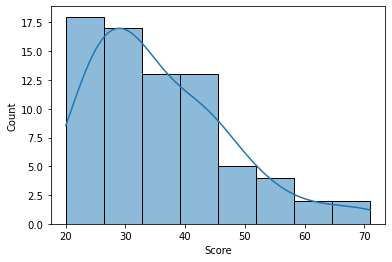

In [5]:
print(pg.normality(df['Score']))

sns.histplot(x='Score', data=df, kde=True)

### Outlier detection

C:\ProgramData\Anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


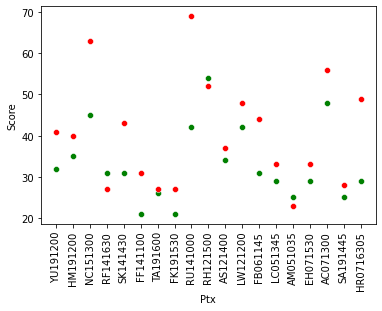

In [6]:
mask1=(df['Condition'] == 'Stress') & (df['Test'] == 'Pre')
mask2=(df['Condition'] == 'Stress') & (df['Test'] == 'Post')
mask3=(df['Condition'] == 'Calm') & (df['Test'] == 'Pre')
mask4=(df['Condition'] == 'Calm') & (df['Test'] == 'Post')

ax1 = sns.scatterplot(x='Ptx',y='Score',data=df[mask1],color='g')
ax2 = sns.scatterplot(x='Ptx',y='Score',data=df[mask2],color='r')

ax1.tick_params(axis='x', rotation=90)

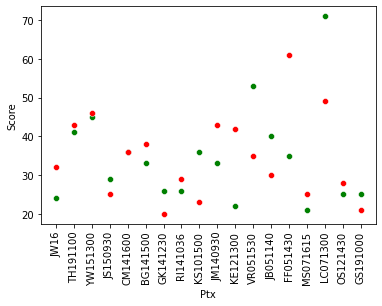

In [7]:
mask1=(df['Condition'] == 'Stress') & (df['Test'] == 'Pre')
mask2=(df['Condition'] == 'Stress') & (df['Test'] == 'Post')

mask3=(df['Condition'] == 'Calm') & (df['Test'] == 'Pre')
mask4=(df['Condition'] == 'Calm') & (df['Test'] == 'Post')

ax1 = sns.scatterplot(x='Ptx',y='Score',data=df[mask3],color='g')
ax2 = sns.scatterplot(x='Ptx',y='Score',data=df[mask4],color='r')

ax1.tick_params(axis='x', rotation=90)

### Measure the mean difference of each ptx

In [8]:
# Pivot the DataFrame to get Pre and Post scores on separate columns for each Ptx and Condition
pivoted_df = df.pivot(index=['Ptx', 'Condition'], columns='Test', values='Score')

# Calculate the difference (Post - Pre) and reset the index to make Ptx and Condition columns again
pivoted_df['Difference'] = pivoted_df['Post'] - pivoted_df['Pre']
result_df = pivoted_df.reset_index()

result_df.head(5)


Test,Ptx,Condition,Post,Pre,Difference
0,AC071300,Stress,56,48,8
1,AM051035,Stress,23,25,-2
2,AS121400,Stress,37,34,3
3,BG141500,Calm,38,33,5
4,CM141600,Calm,36,36,0


### Normality distribution test for difference

                   W      pval  normal
Difference  0.969868  0.404767    True


<AxesSubplot:xlabel='Difference', ylabel='Count'>

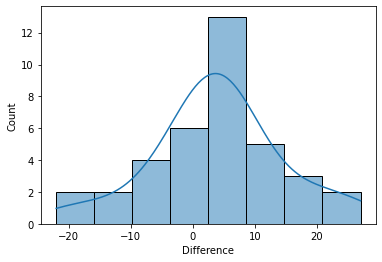

In [9]:
print(pg.normality(result_df['Difference']))

sns.histplot(x='Difference', data=result_df, kde=True)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Calm v.s. Stress: Welch's t-test independent samples with Bonferroni correction, P_val=4.233e-02 stat=-2.123e+00


<ipython-input-10-cfba9b18dac7>:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inch" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("PrePost_Difference.png", dpi=450, bbox_inch=True)


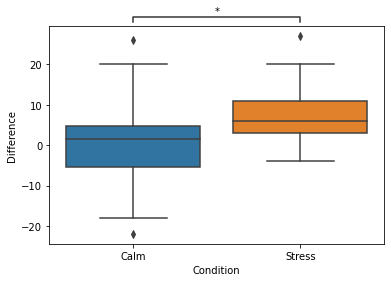

In [10]:
order = ['Calm', 'Stress']
x='Condition'
y='Difference'

box_pairs = [['Stress', 'Calm']]
ax1 = sns.boxplot(x=x, y=y, order=order, data=result_df)

test_results = add_stat_annotation(ax1, data=result_df, x=x, y=y, order=order,
                                   box_pairs=box_pairs,
                                   test='t-test_welch', text_format='star',
                                   loc='outside', verbose=2)

plt.savefig("PrePost_Difference.png", dpi=450, bbox_inch=True)

In [30]:
mask = (result_df['Condition'] == 'Calm')
print('Mean calm: ' + str(np.round(np.mean(result_df[mask]['Difference']),3)) + " SD: " + str(np.round(np.std(result_df[mask]['Difference']),3)))

mask = (result_df['Condition'] == 'Stress')
print('Mean stress: ' + str(np.round(np.mean(result_df[mask]['Difference']),3)) + " SD: " + str(np.round(np.std(result_df[mask]['Difference']),3)))

Mean calm: 0.278 SD: 11.661
Mean stress: 7.421 SD: 7.735


### Then that tells you to apply a non-parametric test, e.g. Friedman test (pinch of salt)

In [11]:
pg.anova(dv='Difference', between='Condition', effsize="np2", data=result_df).round(3)

C:\ProgramData\Anaconda3\lib\site-packages\pingouin\parametric.py:992: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  sserror = grp.apply(lambda x: (x - x.mean()) ** 2).sum()


,Source,ddof1,ddof2,F,p-unc,np2
0,Condition,1,35,4.606,0.039,0.116


In [12]:
pg.mixed_anova(dv='Score', between='Condition', within='Test',
               subject='Ptx', effsize="ng2", data=df).round(3)

C:\ProgramData\Anaconda3\lib\site-packages\pingouin\parametric.py:551: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ss_resall = grp_with.apply(lambda x: (x - x.mean()) ** 2).sum()
C:\ProgramData\Anaconda3\lib\site-packages\pingouin\parametric.py:992: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)


,Source,SS,DF1,DF2,MS,F,p-unc,ng2,eps
0,Condition,91.893,1,35,91.893,0.428,0.517,0.010,NaN
1,Test,288.054,1,35,288.054,5.626,0.023,0.030,1.0
2,Interaction,235.825,1,35,235.825,4.606,0.039,0.025,NaN


### Before the post-hoc test, let's look at the distribution for the individual conditions we are about to compare

In [13]:
mask1=(df['Condition'] == 'Stress') & (df['Test'] == 'Pre')
mask2=(df['Condition'] == 'Stress') & (df['Test'] == 'Post')
mask3=(df['Condition'] == 'Calm') & (df['Test'] == 'Pre')
mask4=(df['Condition'] == 'Calm') & (df['Test'] == 'Post')

# print(pg.normality(df[mask1]['Score']))
# print(pg.normality(df[mask2]['Score']))
# print(pg.normality(df[mask3]['Score']))
# print(pg.normality(df[mask4]['Score']))

pg.ttest(df[mask4]['Score'],df[mask2]['Score'], paired=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.464211,34.56298,two-sided,0.152173,"[-13.85, 2.25]",0.47937,0.731,0.294127


### Post-Hoc test i.e. pairwise comparisons between all the condition in order to ...
disentangle where the significance in the Test (Pre-Post) and where the significance in the interaction happens 

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Stress_Pre v.s. Stress_Post: Mann-Whitney-Wilcoxon test greater with Bonferroni correction, P_val=9.603e-01 U_stat=1.210e+02
(<AxesSubplot:xlabel='Condition', ylabel='Score'>, [<statannot.StatResult.StatResult object at 0x000002041D98D8E0>])


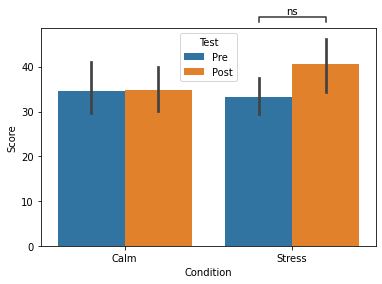

In [14]:
order = ['Calm', 'Stress']
x='Condition'
y='Score'
hue='Test'
# box_pairs = [(('Calm','Pre'), ('Calm','Post')),
#              (('Stress','Pre'), ('Stress','Post')),
#              (('Calm','Pre'), ('Stress','Pre')),
#              (('Calm','Post'), ('Stress','Post'))]

box_pairs = [(('Stress','Pre'), ('Stress','Post'))]

# This is the main plot without the pairwise comparisons 
ax1 = sns.barplot(x=x, y=y, hue=hue, order=order, data=df)

test_results = add_stat_annotation(ax1, data=df, x=x, y=y, order=order,hue=hue,
                                   box_pairs=box_pairs,
                                   test='Mann-Whitney-gt', text_format='star',
                                   loc='outside', verbose=2)

print(test_results)

In [15]:
posthocs = pg.pairwise_tests(dv='Score', within='Test', subject='Ptx',
                              between='Condition', padjust='bonf', data=df)

posthocs.round(3)

C:\ProgramData\Anaconda3\lib\site-packages\pingouin\pairwise.py:477: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby([subject, f], as_index=False, observed=True, sort=True).mean()
C:\ProgramData\Anaconda3\lib\site-packages\pingouin\pairwise.py:582: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "Parametric"] = parametric


,Contrast,Test,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Test,-,Post,Pre,True,True,2.261,36.000,two-sided,0.030,NaN,NaN,1.675,0.338
1,Condition,-,Calm,Stress,False,True,-0.655,34.987,two-sided,0.517,NaN,NaN,0.377,-0.211
2,Test * Condition,Post,Calm,Stress,False,True,-1.464,34.563,two-sided,0.152,0.304,bonf,0.731,-0.469
3,Test * Condition,Pre,Calm,Stress,False,True,0.371,31.004,two-sided,0.714,1.000,bonf,0.336,0.120
